# Auto-Regression Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
day_df = pd.read_csv('day_averaged.csv')

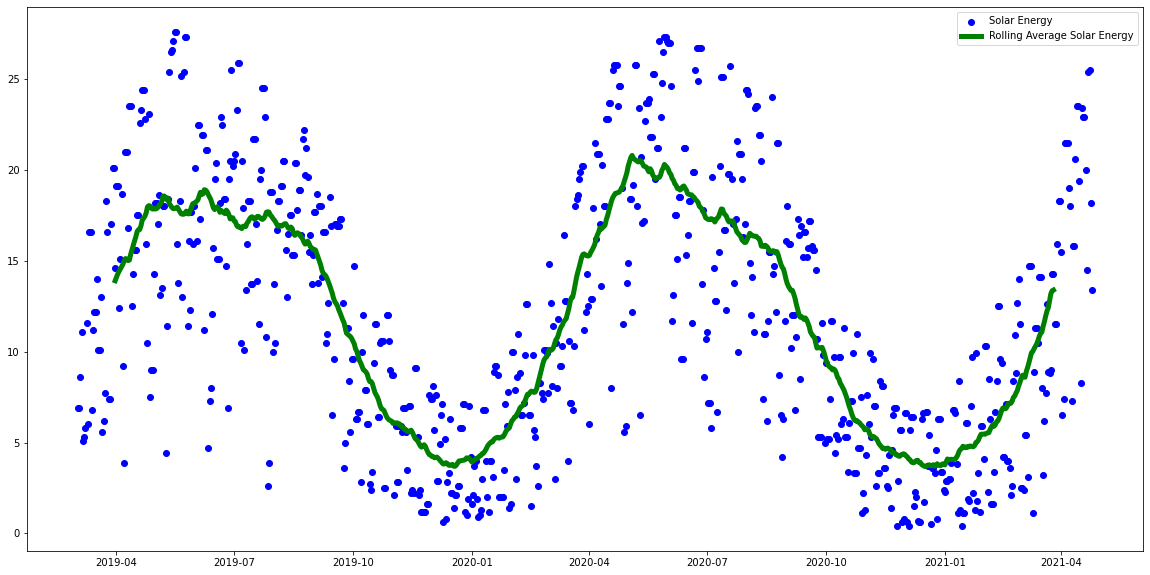

In [17]:
window_size = 60

day_df['rolling_solar'] = day_df['total_solar'].rolling(window=window_size).mean()

plt.figure(figsize=(20,10))

solar_energy_plt = plt.scatter(day_df['date'],day_df['total_solar'], marker='o',color = 'blue', label = 'Solar Energy')
average_energy_plt = plt.plot(day_df['date'],day_df['rolling_solar'].shift(int(-0.5*window_size)), color='green', linewidth=5.0)

plt.legend((solar_energy_plt, average_energy_plt[0]),('Solar Energy', 'Rolling Average Solar Energy'))

(-5.0, 35.0)

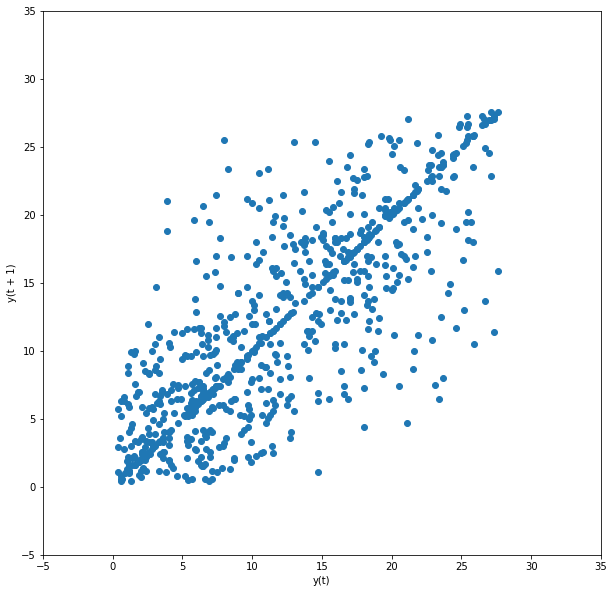

In [5]:
plt.figure(figsize=(10,10))
lag_plot(day_df['total_solar'])
plt.xlim(left=-5, right=35)
plt.ylim(bottom=-5,top = 35)

In [6]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
# Run the test
#
df_stationarityTest = adfuller(day_df['total_solar'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.2981508323448345


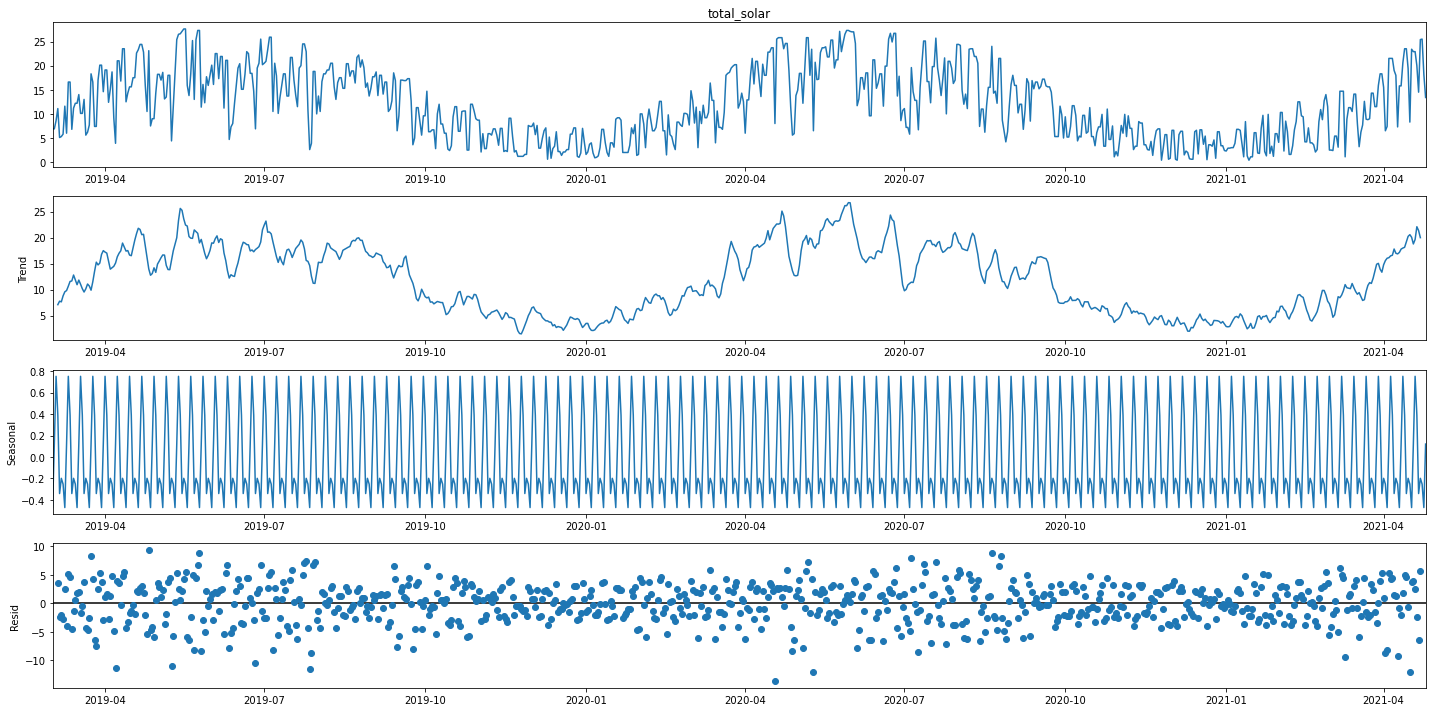

In [7]:
tdi = pd.DatetimeIndex(day_df.date)

day_df.set_index(tdi,inplace=True)

day_df.index.name='datetimeindex'

decomposed = seasonal_decompose(day_df['total_solar'], model='additive')

plt.rcParams["figure.figsize"] = (20,10)
decomposed.plot();

In [8]:
# Estimate Sine fit for data with respect to day in year

day_df['date'] = pd.to_datetime(day_df['date'])
day_df['Day_count'] = day_df['date'].apply(lambda x: (x.to_pydatetime().date() - pd.Timestamp('2018-12-21').to_pydatetime().date()))
day_df['Day_count'] = day_df['Day_count'].dt.days
solar_mean = day_df['total_solar'].mean()
solar_std = (day_df['total_solar']).std()

print(solar_mean)
print(solar_std)

day_df['solar_sin'] = day_df['Day_count'].apply(lambda x: ((1.5*solar_std)*(math.sin((2*math.pi*(x-(365/4))/365))) + solar_mean))

11.912213740458002
7.2934542459888805


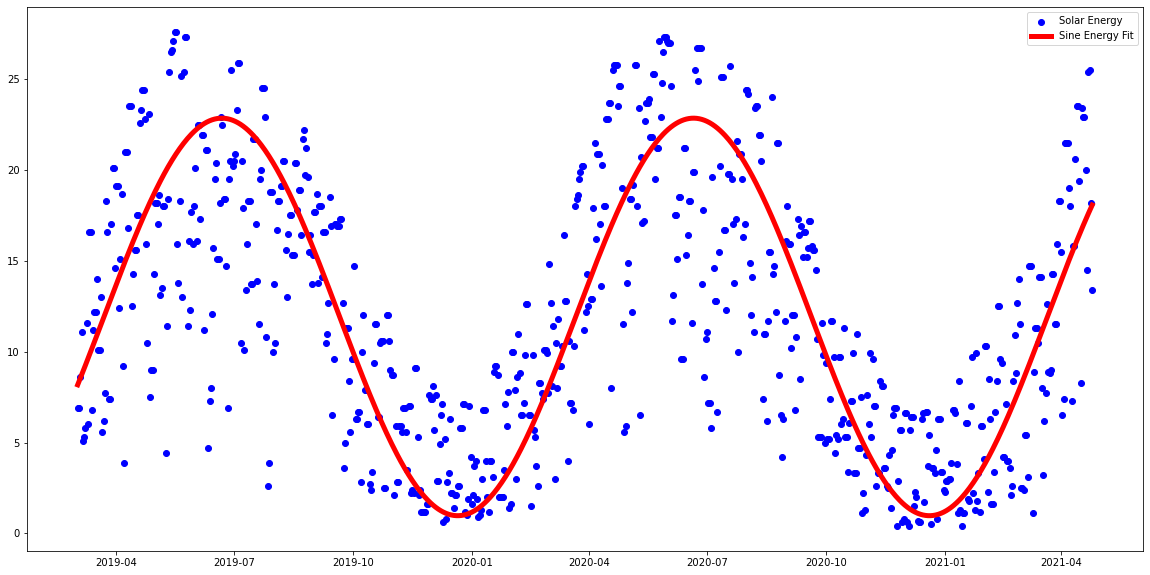

In [9]:
plt.figure(figsize=(20,10))

solar_energy_plt = plt.scatter(day_df['date'],day_df['total_solar'], marker='o',color = 'blue', label = 'Solar Energy')
sine_energy_plt = plt.plot(day_df['date'],day_df['solar_sin'], color='red', linewidth=5.0)

plt.legend((solar_energy_plt, sine_energy_plt[0]),('Solar Energy', 'Sine Energy Fit'))

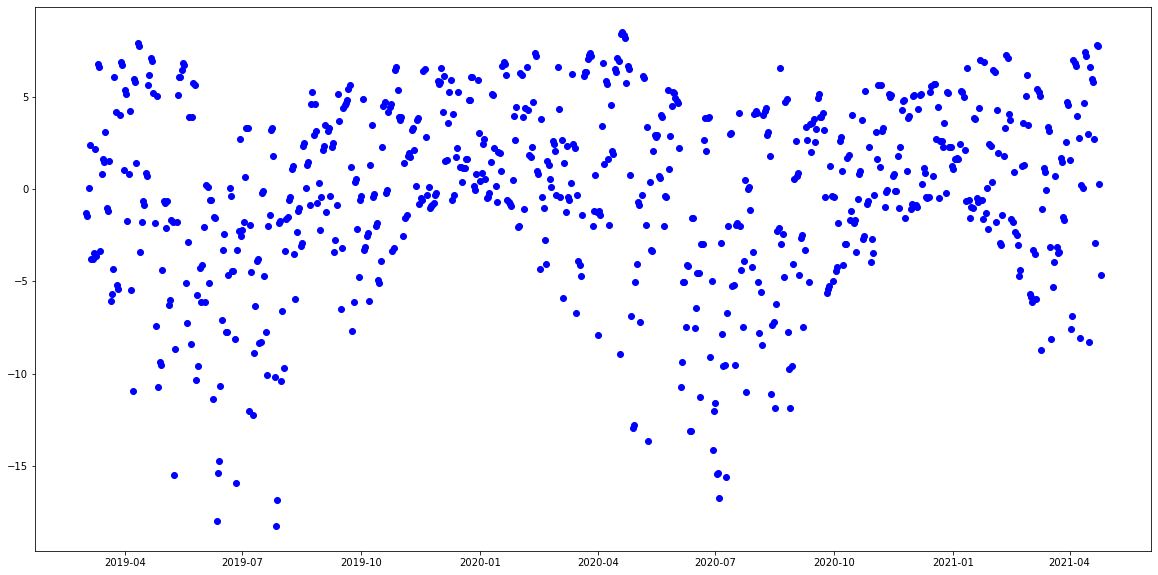

In [10]:
# Remove Trend from data by subtracting estimated sine wave in data

day_df['solar_minus_sine'] = day_df['total_solar'] - day_df['solar_sin']

plt.figure(figsize=(20,10))
solar_energy_plt = plt.scatter(day_df['date'],day_df['solar_minus_sine'], marker='o',color = 'blue', label = 'Solar Minus Sine')

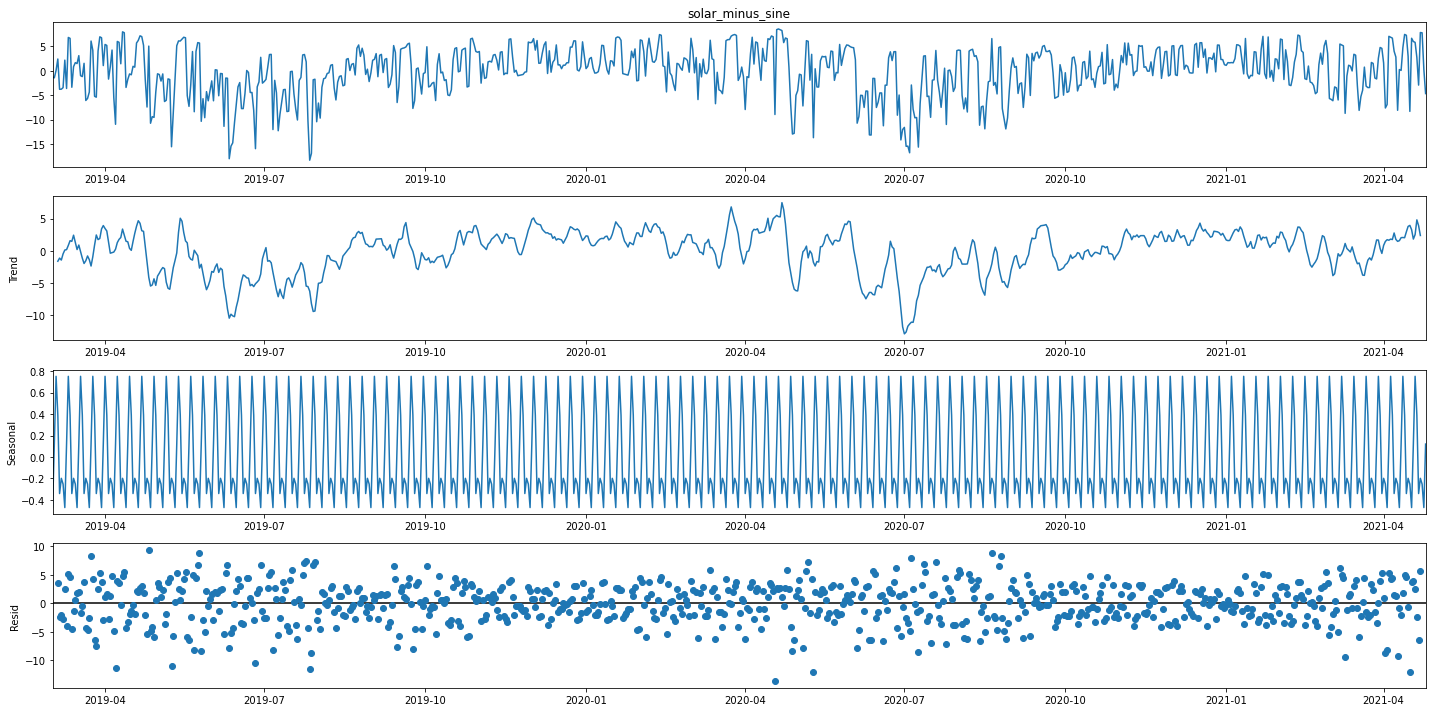

In [11]:
# Re-evalutate decomposition plot for data

decomposed = seasonal_decompose(day_df['solar_minus_sine'], model='additive')

plt.rcParams["figure.figsize"] = (20,10)
decomposed.plot();

In [12]:
# Run the test
#
df_stationarityTest = adfuller(day_df['solar_minus_sine'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.0004263080098411548


The P-value for the data is now below the 5% threshold which suggests that the data now has a level of stationarity which is acceptable to apply an auto-correlation method

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

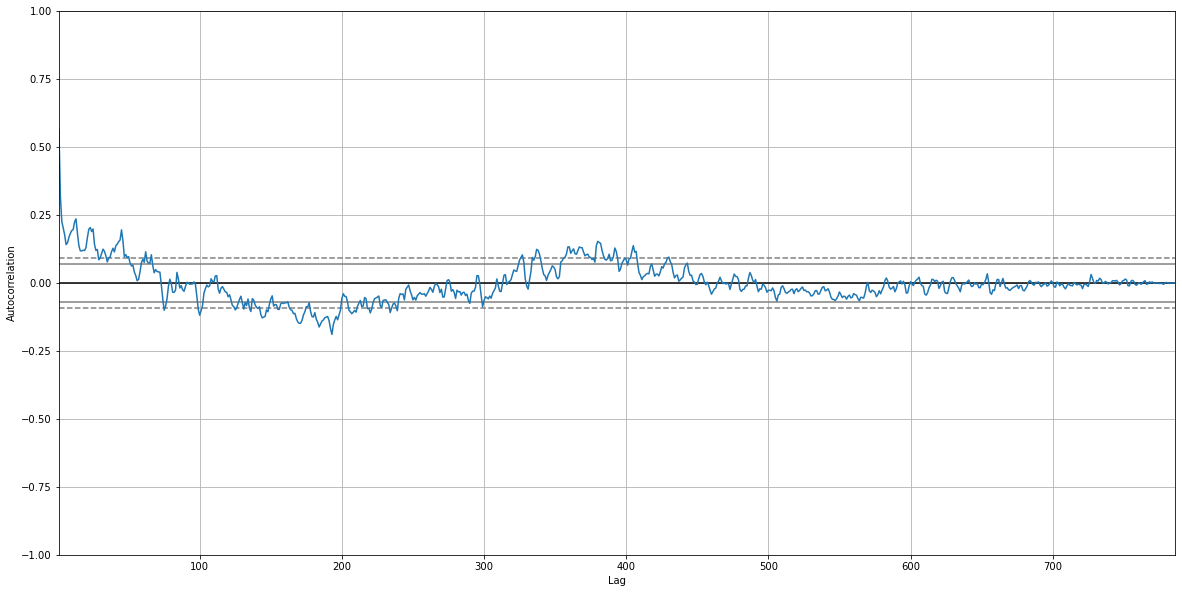

In [13]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10))
autocorrelation_plot(day_df['solar_minus_sine'])

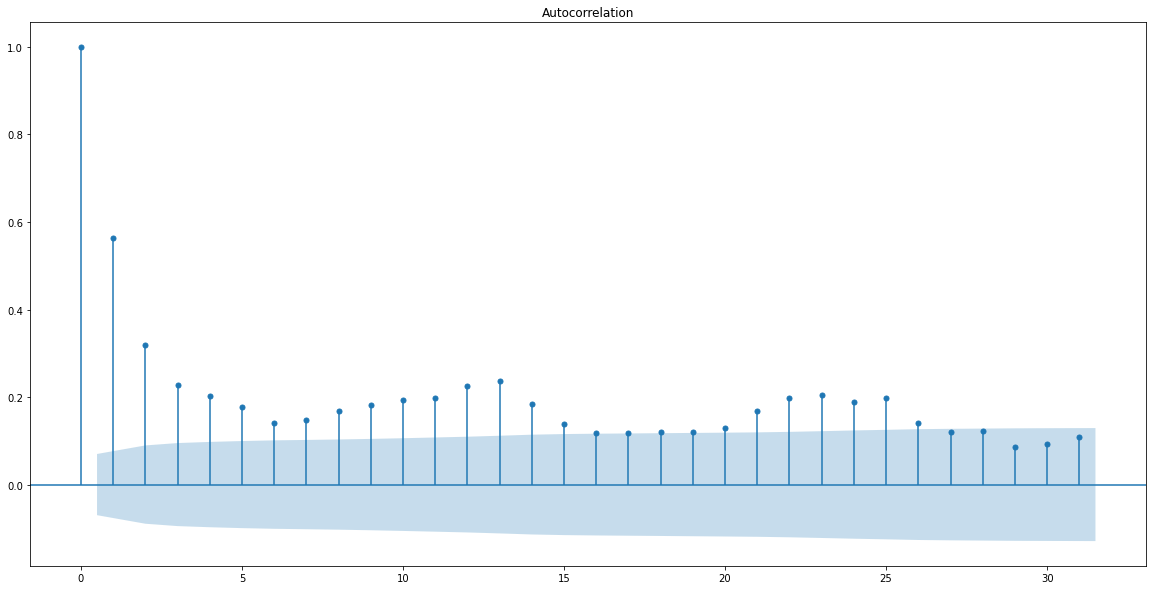

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1,1,figsize=(20,10))
plot_acf(day_df['solar_minus_sine'], ax=ax, lags=31);

In [15]:
from statsmodels.tsa.ar_model import AR

#
# Create training and test data
#
train_data = day_df['solar_minus_sine'][:len(day_df)-int(len(day_df)*0.1)]
test_data = day_df['solar_minus_sine'][len(day_df)-int(len(day_df)*0.1):]
#
# Instantiate and fit the AR model with training data
#
ar_model = AR(train_data).fit()
#
# Print Summary
#
print(ar_model.summary())

                               AR Model Results                               
Dep. Variable:                      s  -                  o                  l
Model:                         AR(20)   Log Likelihood               -1927.983
Method:                          cmle   S.D. of innovations              3.988
Date:                Mon, 08 Nov 2021   AIC                              2.831
Time:                        22:00:38   BIC                              2.976
Sample:                    03-02-2019   HQIC                             2.887
                         - 02-06-2021                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0229      0.155     -0.148      0.883      -0.326       0.281
L1.solar_minus_sine      0.5370      0.039     13.900      0.000       0.461       0.613
L2.solar_min

C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

<AxesSubplot:>

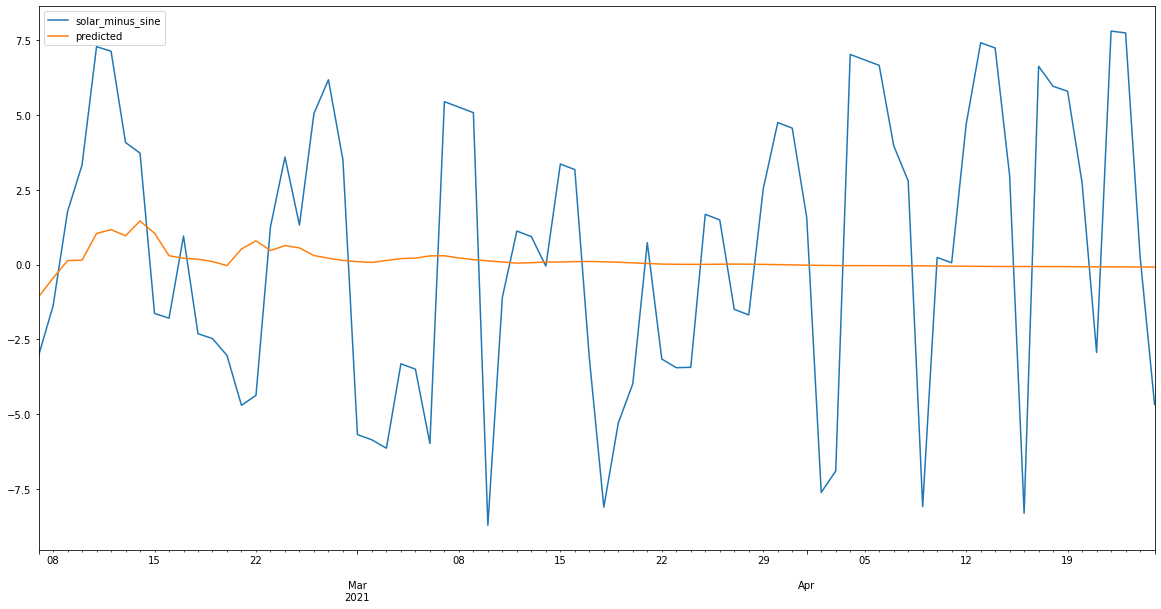

In [16]:
# make predictions 
predictions = ar_model.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [day_df['solar_minus_sine'].tail(int(len(day_df)*0.1)),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()